<a href="https://colab.research.google.com/github/gkumarg/BeeVsWasp/blob/main/Bee_vs_Wasp_MLZoomcamp_HW8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

if not os.path.exists('data.zip'):
  !wget https://github.com/SVizor42/ML_Zoomcamp/releases/download/bee-wasp-data/data.zip
  !unzip data.zip

else:
  print("File exists already. Proceed")

File exists already. Proceed


Import libraries

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import PIL
import PIL.Image
from pathlib import Path
%matplotlib inline

from tensorflow.keras.preprocessing.image import load_img

seed = 2
tf.keras.utils.set_random_seed(seed)
tf.random.set_seed(seed)
tf.config.experimental.enable_op_determinism()



In [3]:
tf.__version__

'2.9.1'

In [4]:
if not tf.__version__ == '2.9.1':
  !pip install tensorflow==2.9.1


In [5]:
tf.__version__

'2.9.1'

### Dataset Exploration

In [6]:
!ls data/train/wasp/984*.jpg

data/train/wasp/9846110345_5f87f85eeb_m.jpg  data/train/wasp/9846164973_4245decd39_w.jpg


In [7]:
train_data_dir = Path('./data/train')
image_count = len(list(train_data_dir.glob('*/*.jpg')))
print(image_count)

3677


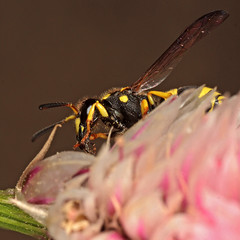

In [8]:
path = './data/train/wasp/'
name = '9846110345_5f87f85eeb_m.jpg'
fullname = f'{path}/{name}'
load_img(fullname)

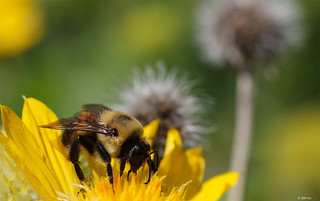

In [9]:
path = './data/train/bee/'
name = '21543926312_b2dc00c7b8_n.jpg'
fullname = f'{path}/{name}'
load_img(fullname)

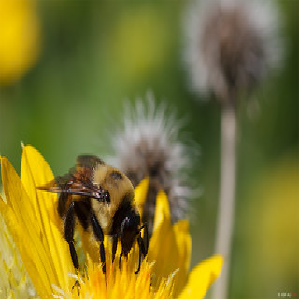

In [10]:
img = load_img(fullname, target_size=(299,299))
img

### Pre-trained Model example

In [13]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input, decode_predictions

Xceptionmodel = Xception(weights='imagenet', #model that was pre-trained on imagenet
                input_shape=(299,299,3)) # we have to use 299,299,3 here

91884032/91884032 [==============================] - 0s 0us/step


In [14]:
x = np.array(img)
x.shape

(299, 299, 3)

In [15]:
X = np.array([x])
X.shape

(1, 299, 299, 3)

In [16]:
X = preprocess_input(X)
# X[0]

In [17]:
pred = Xceptionmodel.predict(X)

1/1 [==============================] - 8s 8s/step


In [18]:
decode_predictions(pred, top=2)

35363/35363 [==============================] - 0s 0us/step


[[('n02206856', 'bee', 0.9762574), ('n07730033', 'cardoon', 0.00732237)]]

### Modeling for Question 1

In [4]:
batch_size = 32
img_height = 150
img_width  = 150

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory('./data/train',
                                                       seed=seed,
                                                       image_size=(img_height, img_width),
                                                       batch_size=batch_size,
                                                      label_mode='binary')

train_ds

Found 3677 files belonging to 2 classes.


<BatchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

In [8]:
test_ds = tf.keras.utils.image_dataset_from_directory('./data/test',
                                                       seed=seed,
                                                       image_size=(img_height, img_width),
                                                       batch_size=batch_size,
                                                      shuffle=False,
                                                      label_mode='binary')

test_ds

Found 918 files belonging to 2 classes.


<BatchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

In [9]:
class_names = train_ds.class_names
print(class_names)

['bee', 'wasp']


TypeError: ignored

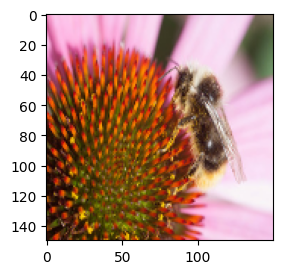

In [10]:
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [38]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

# train_ds = train_gen.flow_from_directory(
#     './data/train',
#     target_size=(150,150),
#     batch_size=32
# )


In [39]:
# test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

# test_ds = test_gen.flow_from_directory(
#     './data/test',
#     target_size=(150,150),
#     batch_size=32
# )

In [11]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 150, 150, 3)
(32, 1)


Model

For this homework we will use Convolutional Neural Network (CNN). Like in the lectures, we'll use Keras.

You need to develop the model with following structure:

The shape for input should be (150, 150, 3)

Next, create a convolutional layer (Conv2D):

Use 32 filters

Kernel size should be (3, 3) (that's the size of the filter)

Use 'relu' as activation

Reduce the size of the feature map with max pooling (MaxPooling2D)

Set the pooling size to (2, 2)

Turn the multi-dimensional result into vectors using a Flatten layer

Next, add a Dense layer with 64 neurons and 'relu' activation

Finally, create the Dense layer with 1 neuron - this will be the output

The output layer should have an activation - use the appropriate activation for the binary classification case

As optimizer use SGD with the following parameters:
```
SGD(lr=0.002, momentum=0.8)
```
For clarification about kernel size and max pooling, check Office Hours.

For Question 1 and 2 we'll start with a basic model without any preprocessing

In [41]:
# AUTOTUNE = tf.data.AUTOTUNE

# train_ds = train_ds.cache().prefetch(buffer_size =AUTOTUNE)
# test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from keras.optimizers import SGD

def get_model():
  model = tf.keras.Sequential(
    [
      tf.keras.layers.Conv2D(32, 3, input_shape=(150,150,3),activation='relu'),
      tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
    ]
    )
  return model

learning_rate = 0.002
momentum = 0.8
opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum)
loss = keras.losses.BinaryCrossentropy()

model = get_model()
model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])



In [13]:
history = model.fit(train_ds, epochs=10, validation_data=test_ds)

Epoch 1/10
115/115 [==============================] - 8s 43ms/step - loss: 141.3650 - accuracy: 0.5341 - val_loss: 0.6904 - val_accuracy: 0.5436
Epoch 2/10
115/115 [==============================] - 7s 61ms/step - loss: 0.6906 - accuracy: 0.5434 - val_loss: 0.6902 - val_accuracy: 0.5392
Epoch 3/10
115/115 [==============================] - 6s 50ms/step - loss: 0.6906 - accuracy: 0.5431 - val_loss: 0.6935 - val_accuracy: 0.5501
Epoch 4/10
115/115 [==============================] - 5s 40ms/step - loss: 0.6868 - accuracy: 0.5491 - val_loss: 0.7024 - val_accuracy: 0.5632
Epoch 5/10
115/115 [==============================] - 7s 62ms/step - loss: 0.6923 - accuracy: 0.5428 - val_loss: 0.6904 - val_accuracy: 0.5381
Epoch 6/10
115/115 [==============================] - 5s 43ms/step - loss: 0.6903 - accuracy: 0.5377 - val_loss: 0.6903 - val_accuracy: 0.5381
Epoch 7/10
115/115 [==============================] - 5s 40ms/step - loss: 0.6903 - accuracy: 0.5377 - val_loss: 0.6903 - val_accuracy: 0.53

In [14]:
score = model.evaluate(test_ds)

29/29 [==============================] - 1s 31ms/step - loss: 0.6901 - accuracy: 0.5370


In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 175232)            0         
                                                                 
 dense (Dense)               (None, 64)                11214912  
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 11,215,873
Trainable params: 11,215,873
Non-trainable params: 0
____________________________________________

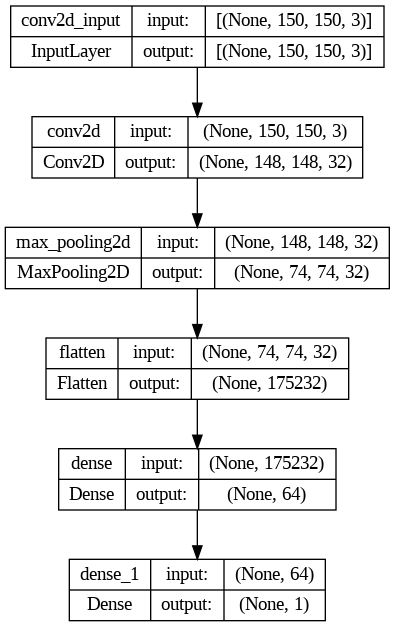

In [16]:
keras.utils.plot_model(model, show_shapes=True)

### Question 1
Since we have a binary classification problem, what is the best loss function for us?

mean squared error

binary crossentropy  <<--- Answer

categorical crossentropy

cosine similarity

Note: since we specify an activation for the output layer, we don't need to set ``` from_logits=True```

### Question 2

What's the number of parameters in the convolutional layer of our model? You can use the summary method for that.

1

65

896  <<--- as seen above

11214912




### Generators and Training

For the next two questions, use the following data generator for both train and test sets:

`ImageDataGenerator(rescale=1./255)`

We don't need to do any additional pre-processing for the images.
When reading the data from train/test directories, check the class_mode parameter. Which value should it be for a binary classification problem?
Use batch_size=20
Use shuffle=True for both training and test sets.
For training use .fit() with the following params:

`
model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator
)
`

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

train_ds = train_gen.flow_from_directory('./data/train',
                                         target_size=(150,150),
                                         class_mode='binary',
                                         batch_size=20,
                                         shuffle=True,
                                         seed=seed
                                         )


Found 3677 images belonging to 2 classes.


In [18]:
test_ds = test_gen.flow_from_directory('./data/test',
                                         target_size=(150,150),
                                         class_mode='binary',
                                         batch_size=20,
                                         shuffle=True,
                                         seed=seed
                                         )

Found 918 images belonging to 2 classes.


In [19]:
X, y = next(train_ds)

In [20]:
X.shape

(20, 150, 150, 3)

In [21]:
y.shape

(20,)

In [22]:
train_ds.class_indices

{'bee': 0, 'wasp': 1}

In [23]:
y[:3]

array([0., 1., 0.], dtype=float32)

In [24]:
history = model.fit(train_ds, epochs=10, validation_data=test_ds)

Epoch 1/10
184/184 [==============================] - 12s 60ms/step - loss: 0.6904 - accuracy: 0.5372 - val_loss: 0.6904 - val_accuracy: 0.5370
Epoch 2/10
184/184 [==============================] - 11s 61ms/step - loss: 0.6904 - accuracy: 0.5374 - val_loss: 0.6904 - val_accuracy: 0.5364
Epoch 3/10
184/184 [==============================] - 10s 53ms/step - loss: 0.6904 - accuracy: 0.5373 - val_loss: 0.6904 - val_accuracy: 0.5372
Epoch 4/10
184/184 [==============================] - 10s 56ms/step - loss: 0.6904 - accuracy: 0.5374 - val_loss: 0.6904 - val_accuracy: 0.5370
Epoch 5/10
184/184 [==============================] - 10s 52ms/step - loss: 0.6904 - accuracy: 0.5374 - val_loss: 0.6904 - val_accuracy: 0.5367
Epoch 6/10
184/184 [==============================] - 11s 57ms/step - loss: 0.6904 - accuracy: 0.5375 - val_loss: 0.6904 - val_accuracy: 0.5368
Epoch 7/10
184/184 [==============================] - 9s 49ms/step - loss: 0.6904 - accuracy: 0.5372 - val_loss: 0.6904 - val_accuracy: 

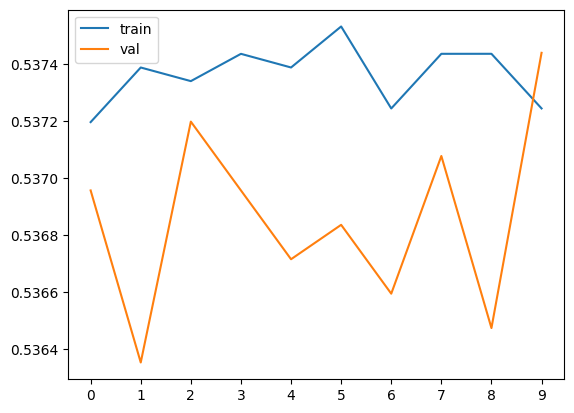

In [25]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xticks(np.arange(10))
plt.legend()
plt.show()

In [26]:
np.median(history.history['accuracy']), np.std(history.history['loss'])

(0.5373880565166473, 1.1389410492208278e-05)

### Question 3
What is the median of training accuracy for all the epochs for this model?

0.20

0.40

0.60 <<-- closest answer

0.80

### Question 4
What is the standard deviation of training loss for all the epochs for this model?

0.031 <<-- closest answer

0.061

0.091

0.131

### Data Augmentation
For the next two questions, we'll generate more data using data augmentations.

Add the following augmentations to your training data generator:

```
rotation_range=50,
width_shift_range=0.1,
height_shift_range=0.1,
zoom_range=0.1,
horizontal_flip=True,
fill_mode='nearest'
```

In [27]:
train_gen = ImageDataGenerator(
    # preprocessing_function=preprocess_input,
    rescale=1./255,
    rotation_range=50,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_ds = train_gen.flow_from_directory('./data/train',
                                         target_size=(150,150),
                                         class_mode='binary',
                                         batch_size=20,
                                         shuffle=True
                                         )


test_gen = ImageDataGenerator(
    # preprocessing_function=preprocess_input,
    rescale=1./255,
)

test_ds = test_gen.flow_from_directory('./data/test',
                                         target_size=(150,150),
                                         class_mode='binary',
                                         batch_size=20,
                                         shuffle=False
                                         )

Found 3677 images belonging to 2 classes.
Found 918 images belonging to 2 classes.


In [28]:
history = model.fit(train_ds, epochs=10, validation_data=test_ds)

Epoch 1/10
184/184 [==============================] - 30s 165ms/step - loss: 0.6904 - accuracy: 0.5375 - val_loss: 0.6904 - val_accuracy: 0.5359
Epoch 2/10
184/184 [==============================] - 33s 178ms/step - loss: 0.6904 - accuracy: 0.5375 - val_loss: 0.6904 - val_accuracy: 0.5359
Epoch 3/10
184/184 [==============================] - 31s 166ms/step - loss: 0.6904 - accuracy: 0.5374 - val_loss: 0.6904 - val_accuracy: 0.5359
Epoch 4/10
184/184 [==============================] - 29s 159ms/step - loss: 0.6904 - accuracy: 0.5374 - val_loss: 0.6904 - val_accuracy: 0.5359
Epoch 5/10
184/184 [==============================] - 31s 171ms/step - loss: 0.6904 - accuracy: 0.5375 - val_loss: 0.6904 - val_accuracy: 0.5359
Epoch 6/10
184/184 [==============================] - 30s 165ms/step - loss: 0.6904 - accuracy: 0.5373 - val_loss: 0.6904 - val_accuracy: 0.5359
Epoch 7/10
184/184 [==============================] - 29s 160ms/step - loss: 0.6904 - accuracy: 0.5375 - val_loss: 0.6904 - val_ac

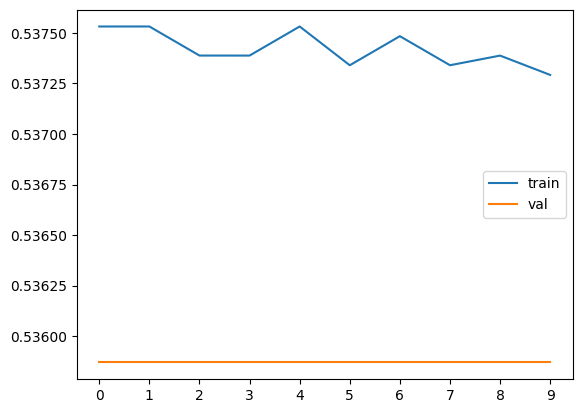

In [29]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xticks(np.arange(10))
plt.legend()
plt.show()


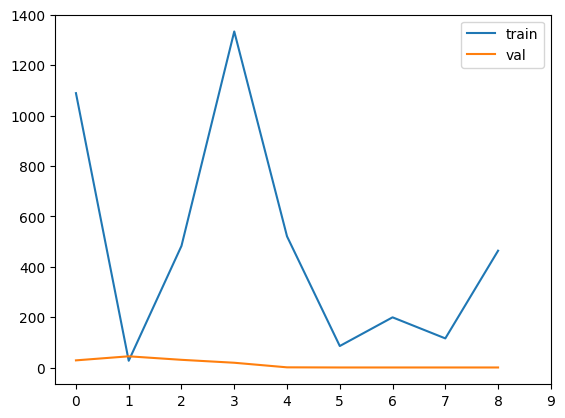

In [42]:
plt.plot(history.history['loss'][1:], label='train')
plt.plot(history.history['val_loss'][1:], label='val')
plt.xticks(np.arange(10))
plt.legend()
plt.show()

In [30]:
np.mean(history.history['val_loss']), np.mean(history.history['val_accuracy'][6:10])

(0.6904018580913543, 0.5358695387840271)

### Question 5

Let's train our model for 10 more epochs using the same code as previously.

Note: make sure you don't re-create the model - we want to continue training the model we already started training.

What is the mean of test loss for all the epochs for the model trained with augmentations?

0.18

0.48

0.78 <<-- closest

0.108




### Question 6

What's the average of test accuracy for the last 5 epochs (from 6 to 10) for the model trained with augmentations?

0.38

0.58 <<-- closest

0.78

0.98